In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../../initialize.py

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphtask import Task
from networkx import topological_generations
from timeit import Timer

In [5]:
def run_experiment(
        secs: float = 0.1,
        static_depth=4,
        dynamic_depth=4,
        n_static_jobs=1,
        n_dynamic_jobs=1,
):
    def sleep():
        time.sleep(secs)
        return None

    t = Task(n_jobs=n_static_jobs)

    names = []
    for i in range(static_depth):
        node_name = f"static_{i}"
        t.step(sleep, rename=node_name)
        names.append(node_name)

    @t.step(args=names)
    def gather_static(*args):
        time.sleep(secs)
        return list(range(dynamic_depth))

    @t.step(map="gather_static", flatten=False, n_jobs=n_dynamic_jobs)
    def dynamic(gather_static):
        time.sleep(secs)

    @t.step
    def gather_dynamic(dynamic):
        time.sleep(secs)

    total_work = len(t._graph.nodes) + dynamic_depth - 1
    critical_path = len(list(topological_generations(t._graph)))
    upper_bound = total_work * secs  # zero overhead
    lower_bound = critical_path * secs  # zero overhead

    timer = Timer(t)
    times = timer.repeat(repeat=10, number=1)
    mean_time = np.mean(times)
    std_time = np.std(times)
    return mean_time, std_time, upper_bound, lower_bound

In [6]:
dynamic = np.concatenate([np.repeat(1, 8), np.arange(1, 9), np.arange(1, 9)])

In [7]:
static = np.concatenate([np.arange(1, 9), np.repeat(1, 8), np.arange(1, 9)])

In [36]:
res = []
for s, d in zip(static, dynamic):
    sub = []
    for n_jobs in [1,2,4,8]:
        mt, st, ub, lb = run_experiment(
            secs=0.1,
            static_depth=s,
            dynamic_depth=d,
            n_static_jobs=min(s, n_jobs),
            n_dynamic_jobs=min(d, n_jobs)
        )
        sub.append((n_jobs, mt, st, ub, lb))

    n_jobs, mt, st, ub, lb = list(zip(*sub))
    res.append({
        "n_static_nodes": s,
        "n_dynamic_nodes": d,
        "n_jobs": n_jobs,
        "mean_time": mt,
        "std_time": st,
        "upper_bound": ub[0],  # always the same
        "lower_bound": lb[0]  # always the same
    })


In [50]:
df = pd.DataFrame(res)

In [38]:
df.to_csv("sleep-study.csv")

In [68]:
from ast import literal_eval
df = pd.read_csv("theoretical-experiment.csv", index_col=0)
df.n_jobs = df.n_jobs.apply(literal_eval)
df.mean_time = df.mean_time.apply(literal_eval)
df.std_time = df.std_time.apply(literal_eval)
static_df, dynamic_df, combined_df = df.iloc[:8, :], df.iloc[8:16, :], df.iloc[16:, :]

In [92]:
def plot_experiment(df, xlabel: str, xticks):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    ax.plot(df.upper_bound.values, "--", label="sequential bound", c="gray", )
    ax.plot(df.lower_bound.values, "--", label="parallel bound", c="darkgray")

    mean_times = np.stack(df.mean_time).T
    std_times = np.stack(df.std_time).T
    n_jobs = np.stack(df.n_jobs).T
    for i, (mt, st, nj) in enumerate(zip(mean_times, std_times, n_jobs)):
        ax.plot(mt, label="time (mean)" if i == 0 else "", c="black")
        ax.fill_between(
            range(len(mt)),
            mt - st,
            mt + st,
            color="lightgray",
            label="time (std)" if i == 0 else ""
        )
        ax.annotate(f"n={nj[0]}", xy=(7-0.7, mt[-1] + 0.025))

    ax.set_ylabel("seconds")
    ax.set_xlabel(xlabel)
    ax.set_xticks(range(len(df)), labels=xticks)
    ax.legend()
    fig.tight_layout()
    return fig

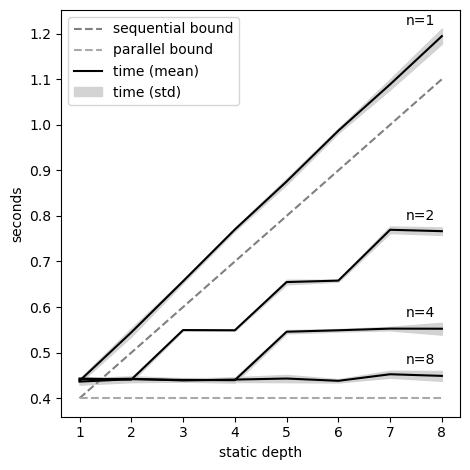

In [93]:
fig = plot_experiment(static_df, "static depth", range(1, 9))
fig.savefig("static-depth.pdf")

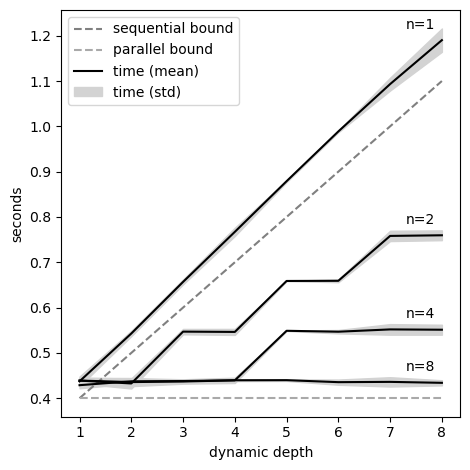

In [94]:
fig = plot_experiment(dynamic_df, "dynamic depth", range(1, 9))
fig.savefig("dynamic-depth.pdf")

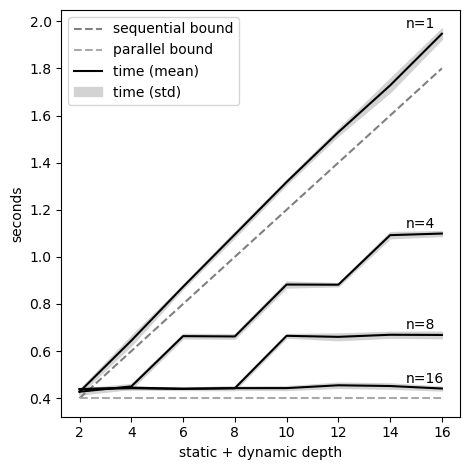

In [95]:
fig = plot_experiment(combined_df, "static + dynamic depth", list(range(2, 17, 2)))
fig.savefig("combined-depth.pdf")

In [91]:
import pandas as pd

df = pd.read_csv("case-study.csv", index_col=0)

In [27]:
def plot_case_study(df):
    fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
    n_jobs, mt, st = list(range(1,13)), df["mean"].values, df["std"].values
    ax.plot(mt, label="time (mean)", c="black")
    ax.fill_between(
        range(len(df)),
        mt - st,
        mt + st,
        color="lightgray",
        label="time (std)"
    )

    ax.set_ylabel("seconds")
    ax.set_xlabel("workers")
    ax.set_xticks(range(len(df)), labels=n_jobs)
    ax.legend()
    return fig

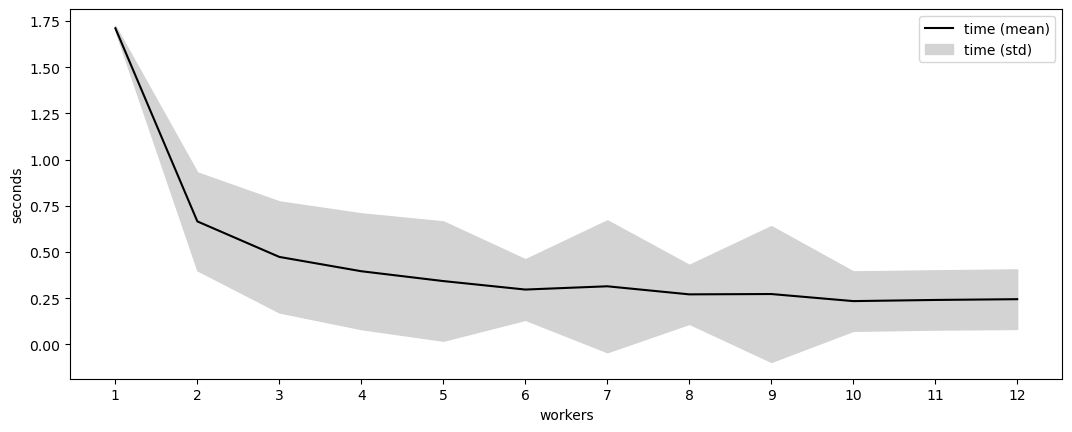

In [28]:
fig = plot_case_study(df)
fig.savefig("case-study.pdf")